# Notebook 2

- If you work on Google Colab, [![open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jouvetg/glamod/blob/main/02_notebook/glacier-modelling-2.ipynb) and you will donwload the repo  below. Make sure to activate the GPU on Colab "Runtime" -> "Change Runtime Type" -> Slect GPU.

- If you work locally on your own PC, you can download the repo
```bash
git clone --depth 1 https://github.com/jouvetg/glamod.git
```
and then go the notebook folder, and work from there.

## Goals of this notebook

   - Get familiar with model IGM
   - Understand the parameters, set-up your model
   - Run IGM examples
   - Customization, run IGM for your own glacier

## What is IGM?

Here we will use the glacier evolution model developed at UNIL -- the Instructed Glacier Model.

The IGM is an open-source Python package, which permits to simulate 3D glacier evolution accounting for the coupling between ice thermo-dynamics, surface mass balance, and mass conservation. IGM is especially computationally efficient thanks to the TensorFlow library, mathematical operations are fully-vectorized. This permits important speed-ups on [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) (Graphics Processing Units), which are devices made of many processors, and can therefore perform highly-parallelized computations.

All the documentation can be found at [https://igm-model.org/](https://igm-model.org/).

## How to install IGM?

Running IGM consists of running a python script `igm_run`, which is made of functions of the `igm` python package.  First of all, one needs to install igm as follows: (this may take a while, and it may crashes the first time, but should work the second time).

In [ ]:
! pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple igm-model-testing-package==3.0.5

In this notebook, we will explore 3 model runs with increasing complexity:

- A first basic run with a simple surface mass balance model
- A second one that works for any glacier, with a more elaborate SMB
- A third with a user-defined SMB and particle tracking

## Download the data

Let's now download the repo with the data if you are using Colab

In [1]:
import sys, os

if "google.colab" in sys.modules:
    print("Running in Colab: cloning repo...")
    !git clone --depth 1 https://github.com/jouvetg/glamod.git
    !apt-get install tree -q
else:
    print("Running locally: using local files.")

Running in Colab: cloning repo...
Cloning into 'glamod'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 69 (delta 4), reused 55 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 14.04 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (40.2 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tr

Let's now go the working folder

In [2]:
if "google.colab" in sys.modules:
    %cd /content/glamod/02_notebook

/content/glamod/02_notebook


## First run with IGM

### Folder exploration

Let us explore the directory with the following command:

In [3]:
!tree

.
├── data
│   └── input-aletsch.nc
├── experiment
│   ├── params_0.yaml
│   ├── params_1.yaml
│   └── params_2.yaml
├── glacier-modelling-2.ipynb
├── helper.py
└── user
    ├── code
    │   └── processes
    │       └── mysmb.py
    └── conf
        └── processes
            └── mysmb.yaml

7 directories, 8 files


You will see the following files :

```bash
.
├── data                 # This folder contains all input data
├── experiment           # This folder contains the parameters
│   ├── params_0.yaml
│   ├── ...
└── user                 # This folder contains user code
    ├── code
    └── conf
```

### Parameter file exploration

If you look at the parameter file, you will see the following content, which shows all the input, process, and output modules along with all their parameters. Below, you may notice that IGM: i) first loads a certain number of inputs, processes, and output modules, ii) second defines parameters associated with each module that deviate from default ones.

Here is the content of `params_0.yaml`, taken from IGM's example `aletsch-basic`. Here, IGM loads data with the `local` module, proceeds to a simulation from 1900 to 2000 updating surface mass balance (`smb`), iceflow, time, and ice thickness. Then, it writes the results in both a local file (NetCDF file) and in the form of plots.

```yaml title="params_0.yaml"
# @package _global_

defaults:
  - override /inputs:
    - local                    # load local input module
  - override /processes:
    - smb_simple               # load smb_simple processes module
    - iceflow                  # load iceflow processes module
    - time                     # load time processes module
    - thk                      # load thk processes module
  - override /outputs:
    - local                    # load local outputs module
    - plot2d                   # load plot2d outputs module

inputs:
  local:
     filename: input-aletsch.nc   # The local model will load the input-aletsch.nc file

processes:
  smb_simple:
    array:
      - ["time", "gradabl", "gradacc", "ela", "accmax"]
      - [1900, 0.009, 0.005, 2800, 2.0]
      - [2000, 0.009, 0.005, 2900, 2.0]
      - [2100, 0.009, 0.005, 3300, 2.0]
  time:
    start: 1900.0
    end: 2000.0
    save: 10.0
    
outputs:
  plot2d:
    live: False
```

IGM is organized **module-wise** as shown in the following flowchart:

![](https://igm-model.org/latest/modules/flowchat-module.png)

As a user, you need to pick an ensemble of modules from existing ones (or you may create some user ones), and then define the parameters that deviate from default ones.

### Exploring the data (`input.nc`)

Before running IGM, it's useful to explore the input data file. The `input.nc` file is a NetCDF file that contains all the necessary spatial data for the glacier simulation, such as the bed topography, initial ice thickness, and other geographic information.

We can use the `xarray` library to easily load and explore NetCDF files. Let's look at what's inside the `input.nc` file:

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the NetCDF file
ds = xr.open_dataset('data/input-aletsch.nc')

# Display the dataset structure
print("Dataset structure:")
print(ds)
print("\n" + "="*60 + "\n")

# Show data variables
print("Data variables:")
for var in ds.data_vars:
    print(f"  - {var}: {ds[var].attrs.get('long_name', 'No description')}")
    print(f"    Shape: {ds[var].shape}, Units: {ds[var].attrs.get('units', 'N/A')}")
print("\n" + "="*60 + "\n")

Dataset structure:
<xarray.Dataset> Size: 526kB
Dimensions:  (y: 244, x: 179)
Coordinates:
  * y        (y) float32 976B 5.136e+06 5.136e+06 ... 5.16e+06 5.16e+06
  * x        (x) float32 716B 4.15e+05 4.151e+05 ... 4.327e+05 4.328e+05
Data variables:
    usurf    (y, x) float32 175kB ...
    thk      (y, x) float32 175kB ...
    icemask  (y, x) float32 175kB ...


Data variables:
  - usurf: Surface Topography
    Shape: (244, 179), Units: m
  - thk: Ice Thickness
    Shape: (244, 179), Units: m
  - icemask: Ice mask
    Shape: (244, 179), Units: no unit




Now let's visualize some of the key fields in the input data:

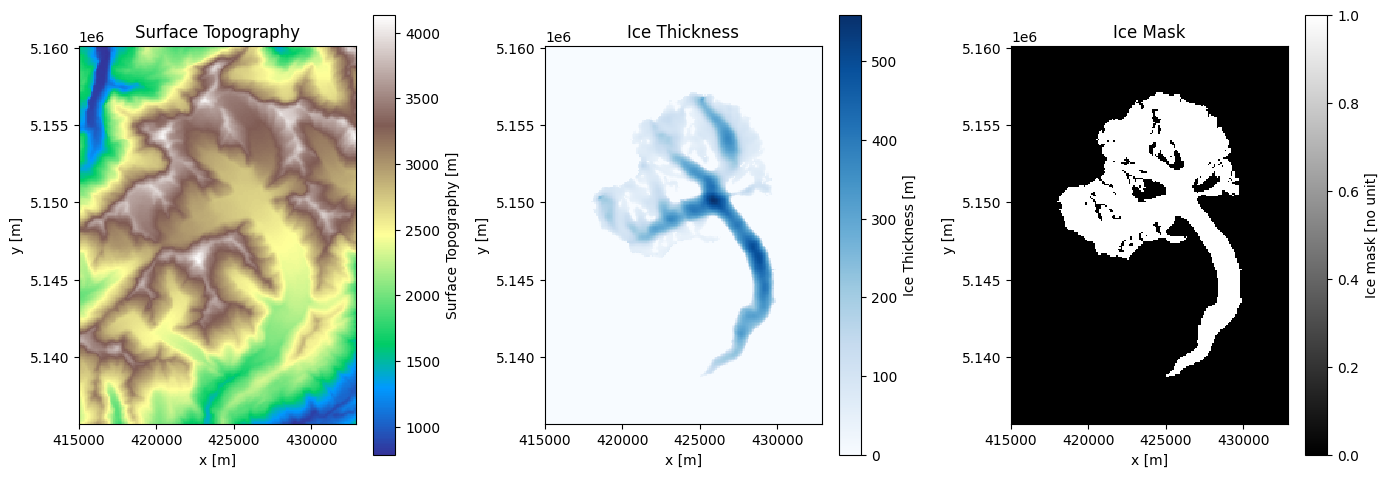

In [5]:
# Create a figure with multiple subplots to visualize the data
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Plot bed topography (topg)
ds['usurf'].plot(ax=axes[0], cmap='terrain')
axes[0].set_title('Surface Topography')
axes[0].set_aspect('equal')

# Plot ice thickness (thk)
ds['thk'].plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Ice Thickness')
axes[1].set_aspect('equal')

# Plot ice mask
ds['icemask'].plot(ax=axes[2], cmap='gray')
axes[2].set_title('Ice Mask')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

What you see above shows raster grids of top surface elevation, ice thickness, and ice mask for the Aletsch Glacier at a spatial resolution of 100 m.

### 'Simple' Surface Mass Balance

The snow accumulation budget (which turns into ice) at altitude and ice melt depends on precipitation and temperature. This mass balance $SMB(z)$ is commonly defined as a function of altitude and depends on different factors:

- A slope that controls the mass balance gradients in both the accumulation $b_\mathrm{acc}$ and the ablation area $b_\mathrm{abl}$
- A maximum value for accumulation $b_\mathrm{max}$
- The altitude of the equilibrium line $z_\mathrm{ELA}$ beyond which ice accumulates and below which ice melts

Mathematically, $SMB(z)$ can be expressed as a piecewise function:

$$
SMB(z) = \begin{cases}
b_\mathrm{abl} \cdot (z - z_\mathrm{ELA}) & \text{if } z < z_\mathrm{ELA} \text{ (ablation zone)} \\
\min(b_\mathrm{acc} \cdot (z - z_\mathrm{ELA}), b_\mathrm{max}) & \text{if } z \geq z_\mathrm{ELA} \text{ (accumulation zone)}
\end{cases}
$$

The code in the next block gives an example of SMB function as a function of elevation $z$.

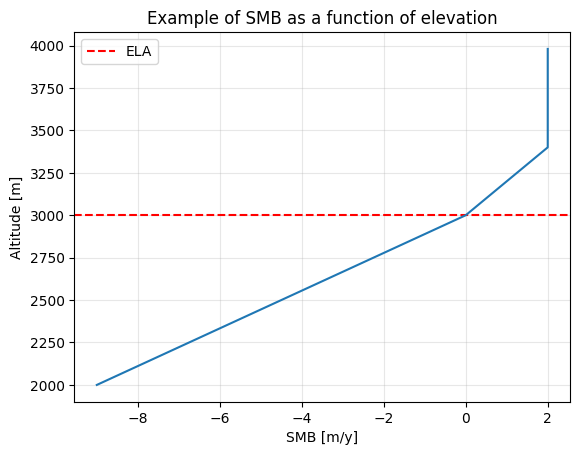

In [6]:
import numpy as np
import matplotlib.pyplot as plt

z_ELA=3000.0
grad_abl=0.009
grad_acc=0.005
b_max=2.0

def smb_fct(elev):
    smb = elev - z_ELA
    smb *= np.where(smb < 0, grad_abl, grad_acc)
    return np.minimum(smb, b_max)

elev = np.arange(2000.0, 4000.0, 20.0)
plt.axhline(y=z_ELA, color='r', linestyle='--', label='ELA')
plt.plot(smb_fct(elev), elev)
plt.ylabel('Altitude [m]')
plt.xlabel('SMB [m/y]')
plt.title('Example of SMB as a function of elevation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Running IGM (`params_0`)

Now, we can run IGM by simply running the command `igm_run +experiment=params_0` (or replace `params_0` with the actual name of your parameter file) in the corresponding folder to execute the example. This will model the evolution of Aletsch Glacier for 100 years given the Surface Mass Balance parameters specified in the parameter file.

In [12]:
!igm_run +experiment=params_0

/bin/bash: line 1: igm_run: command not found


### Explore the output

Each IGM run will generate a folder with the date as the parent folder and the time as a subfolder. For instance, after a few runs we could end up with the following structure:

```bash
outputs
  └───2025-04-07
      ├─── 12-06-29
      └─── 12-07-38
```

In [8]:
!tree

.
├── data
│   └── input-aletsch.nc
├── experiment
│   ├── params_0.yaml
│   ├── params_1.yaml
│   └── params_2.yaml
├── glacier-modelling-2.ipynb
├── helper.py
└── user
    ├── code
    │   └── processes
    │       └── mysmb.py
    └── conf
        └── processes
            └── mysmb.yaml

7 directories, 8 files


After the IGM run, you may have a quick look at the results by exploring:

- Files `velbar_mag-19XX.0.png` that display ice speed and extent over the simulation time
- `output.nc` that stores all the spatio-temporal output results
- `output_ts.nc` that stores all time-dependent volume and area data

Using the helper function, you can visualize the results:

In [9]:
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')
print(f"Found {len(A)} output file(s):", A)

if A:
    # Animate the last run
    animate_glacier_evolution(A[-1])
else:
    print("No output.nc files found. Please run the model first.")

Found 0 output file(s): []
No output.nc files found. Please run the model first.


### Analyzing the time series results

Let's examine how the glacier ice volume and ice area evolved over the simulation period by reading the `output_ts.nc` file:

In [10]:
from helper import *
import glob
import os

# Find all time series files and select the most recent one
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    # Get the absolute path to ensure it works from any directory
    ts_file = os.path.abspath(ts_files[-1])
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    # Analyze the time series from the most recent run
    analyze_time_series(ts_file)
else:
    print("No output_ts.nc file found. Please run the model first.")

No output_ts.nc file found. Please run the model first.


Congratulations! You have successfully run your first glacier model simulation using the IGM package. You can now explore different parameters and scenarios to see how they affect glacier dynamics. Happy modeling!

You may now try to modify some parameters in the configuration file `params_0.yaml` and rerun the simulation to observe how changes impact the glacier's behavior.    

**Tips:** Create a new parameter file by copying `params_0.yaml` to `params_0_student.yaml` and modify it. Then run the simulation with the command `igm_run +experiment=params_0_student`.

## Second run with IGM

The above example is somewhat limited. In a second run, we are making improvements using `params_1.yaml` instead of `params_0.yaml`:

**First improvement:** Instead of using local data, we use the module `oggm_shop` to download all necessary data. The main advantage is that we can order any glacier using their RGI ID, and therefore get the data for any glacier on Earth!

**Second improvement:** OGGM will download climate data (a time series), which will serve to generate a climate (temperature and precipitation in module `clim_oggm`) to compute a better Surface Mass Balance model. Note this parameter in the parameter file:

```yaml
  clim_oggm:
    clim_trend_array:
      - ["time", "delta_temp", "prec_scal"]
      - [ 1900,           0.0,         1.0]
      - [ 2020,           0.0,         1.0]
      - [ 2100,           4.0,         1.0]
```

Similar to the previous method, this array assigns weights to modify precipitation and temperature series based on a *neutral* climate period, typically defined as 1960-1990. By adjusting the temperature offset in the `delta_temp` column, for example, a value of -2.0 would create a climate scenario for the 1960-1990 period that is 2 degrees cooler. Likewise, by modifying the precipitation scaling in the `prec_scal` column, a value of 1.5 would result in a climate scenario that has 150% of the precipitation compared to the 1960-1990 average.

Finally, you can incorporate this parameter to provide global control for melt (note that the melt parameters in the PDD model are notoriously uncertain):

```yaml
   melt_enhancer: 0.7
```

Find more information about the generated climate [here](https://igm-model.org/latest/modules/processes/clim_oggm/).

**Third improvement:** Instead of using the Simple Surface Mass Balance `smb_simple`, and now that we have climate available, we will use the `smb_oggm` SMB, which is a monthly temperature index model as described [here](https://igm-model.org/latest/modules/processes/smb_oggm/).

First explore `params_1.yaml`, then run the following command, which will model the Glacier with RGI ID `RGI60-11.01450` (the Great Aletsch Glacier, Switzerland) from 2020 to 2100, assuming a temperature increase of 4 degrees by 2100 relative to 1960–1990:

In [11]:
! igm_run +experiment=params_1

/bin/bash: line 1: igm_run: command not found


Running the code has created the following output files:

In [ ]:
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')
print(f"Found {len(A)} output file(s):", A)

if A:
    # Animate the last run
    animate_glacier_evolution(A[-1])
else:
    print("No output.nc files found. Please run the model first.")

### Analyzing the time series results

Let's examine how the glacier evolved under the climate scenario:

In [ ]:
from helper import *
import glob
import os

# Find all time series files and select the most recent one
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    # Get the absolute path to ensure it works from any directory
    ts_file = os.path.abspath(ts_files[-1])
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    # Analyze the time series from the most recent run
    analyze_time_series(ts_file)
else:
    print("No output_ts.nc file found. Please run the model first.")

## Third run with IGM

In a third run, we will bring 2 additional new features (explore the parameter file `params_2.yaml`):

**First new feature:** Using a **custom SMB function** that is defined in the `user` folder. Explore the `user` folder and the parameter file `params_2.yaml` to see how custom code can be integrated.

**Second new feature:** We activate a particle tracking module to simulate the displacement of virtual particles within the ice flow. These particles may represent debris or sediments that are transported by the glacier and are responsible for the formation of moraines. Our goal is to model the formation of the main moraine that developed during the Little Ice Age when the glacier reached its maximum extent.

To achieve this, we have added in `params_2.yaml` two modules: `vert_flow` and `particles`. The `vert_flow` module computes vertical velocities (which is not done by default as it is not usually required), while the `particles` module tracks the trajectory of individual particles. It is possible to visualize the moraine formed by looking at the file `velbar_mag-XXXX.0.png`.

Run the following command:

In [ ]:
! igm_run +experiment=params_2